In [47]:
# !pip install pickle5
# !pip install scikit-surprise
import pickle5
# import pickle

import pandas as pd
import numpy as np
from collections import defaultdict 

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

# pd.set_option('display.max_columns', None)

# from google.colab import drive
# drive.mount('/content/drive')

from surprise import Dataset
from surprise import Reader
from surprise import KNNWithMeans, KNNBasic
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV

base_dir = ''

## Utility functions

In [48]:
# Read pickle objects using pickle5.
# Not required for latest python version.
def read_pickle(file):
    with open(file, 'rb') as f:
        data = pickle5.load(f)
    return data
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

def mrr_at_k(predictions, k=10, threshold=3.5):
    user_est_true = defaultdict(list)
    reci_rank = []
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        top_k_recommeded = user_ratings[:k]
        _, actual_ratings = zip(*top_k_recommeded)
        first_positive = np.argmax(np.where(np.array(actual_ratings) >= 3, 1, 0)) + 1
        reci_rank.append(1/first_positive)
    return np.mean(reci_rank)

## Reading Reviews pickle object

In [49]:
# Reading pickle object.
# For latest python version, you can also use pd.read_pickle()
reviews_df = read_pickle(base_dir + 'reviews_curtailed.pkl')
reviews_df = reviews_df[['user_id', 'business_id', 'stars']]
reviews_df.head()

,user_id,business_id,stars
4,UgMW8bLE0QMJDCkQ1Ax5Mg,IS4cv902ykd8wj1TR0N3-A,4.0
5,5vD2kmE25YBrbayKhykNxQ,nlxHRv1zXGT0c0K51q3jDg,5.0
6,aq_ZxGHiri48TUXJlpRkCQ,Pthe4qk5xh4n-ef-9bvMSg,5.0
8,P6apihD4ASf1vpPxHODxAQ,e_BiI4ej1CW1F0EyVLr-FQ,5.0
11,HJECayULRM-6xh2GCCvLiA,l-nL4BmhzpZjcavooO48PQ,4.0


## Filtering users who have rated atleast 50 businesses.

In [50]:
# Counting number of business_id per user_id
reviews_df_group_by_count = reviews_df.groupby('user_id')['business_id'].count().sort_values(ascending = False)

# Filtering users who have rated atleast 50 businesses.
reviews_df = reviews_df[reviews_df.user_id.isin(reviews_df_group_by_count[reviews_df_group_by_count >= 50].reset_index().user_id)]

# To prevent notebook from crashing because of memory limitations
del(reviews_df_group_by_count)

In [51]:
print('Total Number of Users: ', reviews_df.user_id.nunique())
print('Total Number of Businesses: ', reviews_df.business_id.nunique())

Total Number of Users:  5191
Total Number of Businesses:  39277


## Train-Test splitting

Splitting the data by randomly sampling 10 businesses per user and keepling them in the test set.

In [52]:
reader = Reader(rating_scale=(1, 5))
# for each user, randomly sampling '#business_per_user' busineses
trainset, testset = train_test_split(Dataset.load_from_df(reviews_df, reader), test_size=.25)

In [53]:
# train_df = reviews_df.copy()
# # for each user, randomly sampling '#business_per_user' busineses
# test_df = reviews_df.groupby('user_id').sample(n = 10)#frac = 0.3 
# # zeroing the ratings of such selected test_businesses in train set
# train_df.loc[test_df.index, 'stars'] = 0.0

In [54]:
# reader = Reader(rating_scale=(1, 5))
# trainset = Dataset.load_from_df(train_df, reader).build_full_trainset()
# testset = Dataset.load_from_df(test_df, reader).build_full_trainset().build_testset()

In [55]:
# del(reviews_df)

## User Based Collaborative Filtering

### Without Bias

#### Using metric square deviation

In [56]:
results = []

In [57]:
algo = KNNBasic(sim_options={'name': 'msd', 'user_based': True})
algo.fit(trainset)
predictions = algo.test(testset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [58]:
rmse = accuracy.rmse(predictions, verbose=True)
mae = accuracy.mae(predictions, verbose=True)
results.append({'KNNBasic': {'similarity': 'msd', 'user_based': True, 'rmse': rmse, 'mae': mae}})
precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=3)
print('Precision@5: ', sum(prec for prec in precisions.values()) / len(precisions))
print('Recall@5: ', sum(rec for rec in recalls.values()) / len(recalls))
print('MRR@5: ', mrr_at_k(predictions, k=5, threshold=3))

RMSE: 1.1085
MAE:  0.8542
Precision@5:  0.9147017273486359
Recall@5:  0.29259591954116904
MRR@5:  0.9558306042509472


#### Using Cosine Similarity

In [59]:
algo = KNNBasic(sim_options={'name': 'cosine', 'user_based': True})
algo.fit(trainset)
predictions = algo.test(testset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [60]:
rmse = accuracy.rmse(predictions, verbose=True)
mae = accuracy.mae(predictions, verbose=True)
results.append({'KNNBasic': {'similarity': 'cosine', 'user_based': True, 'rmse': rmse, 'mae': mae}})
precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=3)
print('Precision@5: ', sum(prec for prec in precisions.values()) / len(precisions))
print('Recall@5: ', sum(rec for rec in recalls.values()) / len(recalls))
print('MRR@5: ', mrr_at_k(predictions, k=5, threshold=3))

RMSE: 1.1101
MAE:  0.8594
Precision@5:  0.9159346304501581
Recall@5:  0.2932331821071501
MRR@5:  0.9584312592307197


#### Using Pearson Similarity

In [61]:
algo = KNNBasic(sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainset)
predictions = algo.test(testset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [62]:
rmse = accuracy.rmse(predictions, verbose=True)
mae = accuracy.mae(predictions, verbose=True)
results.append({'KNNBasic': {'similarity': 'pearson', 'user_based': True, 'rmse': rmse, 'mae': mae}})
precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=3)
print('Precision@5: ', sum(prec for prec in precisions.values()) / len(precisions))
print('Recall@5: ', sum(rec for rec in recalls.values()) / len(recalls))
print('MRR@5: ', mrr_at_k(predictions, k=5, threshold=3))

RMSE: 1.1690
MAE:  0.8999
Precision@5:  0.9007031400501087
Recall@5:  0.2867870101788038
MRR@5:  0.9491523791177038


### With Bias

#### Using metric square deviation

In [63]:
algo = KNNWithMeans(sim_options={'name': 'msd', 'user_based': True})
algo.fit(trainset)
predictions = algo.test(testset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [64]:
rmse = accuracy.rmse(predictions, verbose=True)
mae = accuracy.mae(predictions, verbose=True)
results.append({'KNNWithMeans': {'similarity': 'msd', 'user_based': True, 'rmse': rmse, 'mae': mae}})
precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=3)
print('Precision@5: ', sum(prec for prec in precisions.values()) / len(precisions))
print('Recall@5: ', sum(rec for rec in recalls.values()) / len(recalls))

print('MRR@5: ', mrr_at_k(predictions, k=5, threshold=3))

RMSE: 1.0526
MAE:  0.8085
Precision@5:  0.9097347974057881
Recall@5:  0.28686185558622723
MRR@5:  0.9558402363064278


#### Using Cosine Similarity

In [65]:
algo = KNNWithMeans(sim_options={'name': 'cosine', 'user_based': True})
algo.fit(trainset)
predictions = algo.test(testset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [66]:
rmse = accuracy.rmse(predictions, verbose=True)
mae = accuracy.mae(predictions, verbose=True)
results.append({'KNNWithMeans': {'similarity': 'cosine', 'user_based': True, 'rmse': rmse, 'mae': mae}})
precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=3)
print('Precision@5: ', sum(prec for prec in precisions.values()) / len(precisions))
print('Recall@5: ', sum(rec for rec in recalls.values()) / len(recalls))
print('MRR@5: ', mrr_at_k(predictions, k=5, threshold=3))

RMSE: 1.0474
MAE:  0.8053
Precision@5:  0.9115263597251866
Recall@5:  0.28727269097344077
MRR@5:  0.9583991523791178


#### Using Pearson Similarity

In [67]:
algo = KNNWithMeans(sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainset)
predictions = algo.test(testset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [68]:
rmse = accuracy.rmse(predictions, verbose=True)
mae = accuracy.mae(predictions, verbose=True)
results.append({'KNNWithMeans': {'similarity': 'pearson', 'user_based': True, 'rmse': rmse, 'mae': mae}})
precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=3)
print('Precision@5: ', sum(prec for prec in precisions.values()) / len(precisions))
print('Recall@5: ', sum(rec for rec in recalls.values()) / len(recalls))
print('MRR@5: ', mrr_at_k(predictions, k=5, threshold=3))

RMSE: 1.1001
MAE:  0.8422
Precision@5:  0.9002568548128387
Recall@5:  0.28335903026272097
MRR@5:  0.9482919154947667


## Item Based Collaborative Filtering

### Without Bias

#### Using metric square deviation

In [69]:
algo = KNNBasic(sim_options={'name': 'msd', 'user_based': False})
algo.fit(trainset)
predictions = algo.test(testset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [70]:
rmse = accuracy.rmse(predictions, verbose=True)
mae = accuracy.mae(predictions, verbose=True)
results.append({'KNNBasic': {'similarity': 'msd', 'user_based': False, 'rmse': rmse, 'mae': mae}})
precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=3)
print('Precision@5: ', sum(prec for prec in precisions.values()) / len(precisions))
print('Recall@5: ', sum(rec for rec in recalls.values()) / len(recalls))
print('MRR@5: ', mrr_at_k(predictions, k=5, threshold=3))

RMSE: 1.0793
MAE:  0.8335
Precision@5:  0.8629262184550393
Recall@5:  0.27113559704757756
MRR@5:  0.9188884607975342


#### Using Cosine Similarity

In [71]:
algo = KNNBasic(sim_options={'name': 'cosine', 'user_based': False})
algo.fit(trainset)
predictions = algo.test(testset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [72]:
rmse = accuracy.rmse(predictions, verbose=True)
mae = accuracy.mae(predictions, verbose=True)
results.append({'KNNBasic': {'similarity': 'cosine', 'user_based': False, 'rmse': rmse, 'mae': mae}})
precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=3)
print('Precision@5: ', sum(prec for prec in precisions.values()) / len(precisions))
print('Recall@5: ', sum(rec for rec in recalls.values()) / len(recalls))
print('MRR@5: ', mrr_at_k(predictions, k=5, threshold=3))

RMSE: 1.0838
MAE:  0.8418
Precision@5:  0.8545463301868823
Recall@5:  0.2678944843968625
MRR@5:  0.9147466769408591


#### Using Pearson Similarity

In [73]:
algo = KNNBasic(sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)
predictions = algo.test(testset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [74]:
rmse = accuracy.rmse(predictions, verbose=True)
mae = accuracy.mae(predictions, verbose=True)
results.append({'KNNBasic': {'similarity': 'pearson', 'user_based': False, 'rmse': rmse, 'mae': mae}})
precisions, recalls = precision_recall_at_k(predictions, k=10, threshold=3)
print('Precision@5: ', sum(prec for prec in precisions.values()) / len(precisions))
print('Recall@5: ', sum(rec for rec in recalls.values()) / len(recalls))
print('MRR@5: ', mrr_at_k(predictions, k=5, threshold=3))

RMSE: 1.1429
MAE:  0.8719
Precision@5:  0.8606697183464773
Recall@5:  0.52694527767038
MRR@5:  0.9195305978295769


### With Bias

#### Using metric square deviation

In [75]:
algo = KNNWithMeans(sim_options={'name': 'msd', 'user_based': False})
algo.fit(trainset)
predictions = algo.test(testset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [76]:
rmse = accuracy.rmse(predictions, verbose=True)
mae = accuracy.mae(predictions, verbose=True)
results.append({'KNNWithMeans': {'similarity': 'msd', 'user_based': False, 'rmse': rmse, 'mae': mae}})
precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=3)
print('Precision@5: ', sum(prec for prec in precisions.values()) / len(precisions))
print('Recall@5: ', sum(rec for rec in recalls.values()) / len(recalls))
print('MRR@5: ', mrr_at_k(predictions, k=5, threshold=3))

RMSE: 1.0583
MAE:  0.8102
Precision@5:  0.912512040069371
Recall@5:  0.28931584623897344
MRR@5:  0.9555223784755668


#### Using Cosine Similarity

In [77]:
algo = KNNWithMeans(sim_options={'name': 'cosine', 'user_based': False})
algo.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [78]:
predictions = algo.test(testset)
rmse = accuracy.rmse(predictions, verbose=True)
mae = accuracy.mae(predictions, verbose=True)
results.append({'KNNWithMeans': {'similarity': 'cosine', 'user_based': False, 'rmse': rmse, 'mae': mae}})
precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=3)
print('Precision@5: ', sum(prec for prec in precisions.values()) / len(precisions))
print('Recall@5: ', sum(rec for rec in recalls.values()) / len(recalls))
print('MRR@5: ', mrr_at_k(predictions, k=5, threshold=3))

RMSE: 1.0561
MAE:  0.8087
Precision@5:  0.9145604572015866
Recall@5:  0.28999107060414714
MRR@5:  0.9555705387529699


#### Using Pearson Similarity

In [79]:
algo = KNNWithMeans(sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)
predictions = algo.test(testset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [80]:
rmse = accuracy.rmse(predictions, verbose=True)
mae = accuracy.mae(predictions, verbose=True)
results.append({'KNNWithMeans': {'similarity': 'pearson', 'user_based': False, 'rmse': rmse, 'mae': mae}})
precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=3)
print('Precision@5: ', sum(prec for prec in precisions.values()) / len(precisions))
print('Recall@5: ', sum(rec for rec in recalls.values()) / len(recalls))
print('MRR@5: ', mrr_at_k(predictions, k=5, threshold=3))

RMSE: 1.1124
MAE:  0.8425
Precision@5:  0.9062544146921139
Recall@5:  0.2870207988818039
MRR@5:  0.9501765876838117


## Visualizing All Results

### User Based Collaborative Filtering

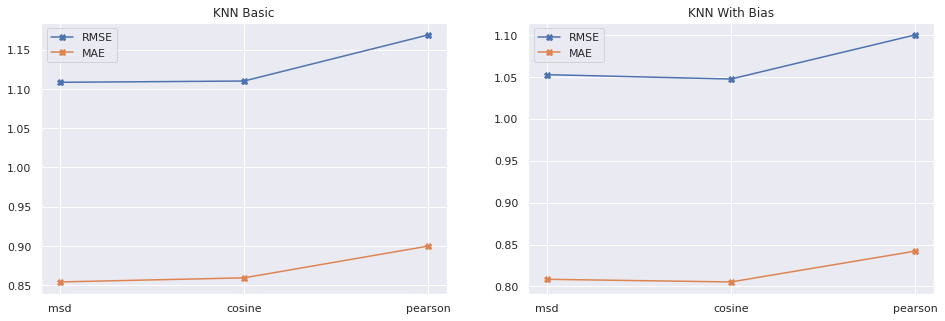

In [81]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

res = [(res['KNNBasic']['similarity'], res['KNNBasic']['rmse'], res['KNNBasic']['mae']) for res in results if 'KNNBasic' in res and res['KNNBasic']['user_based']]
res = list(zip(*res))
metrics, rmse, mae = res[0], res[1], res[2]

axes[0].set_title('KNN Basic')
axes[0].plot(metrics, rmse, '-X', label='RMSE')
axes[0].plot(metrics, mae, '-X', label='MAE')
axes[0].legend()

res = [(res['KNNWithMeans']['similarity'], res['KNNWithMeans']['rmse'], res['KNNWithMeans']['mae']) for res in results if 'KNNWithMeans' in res and res['KNNWithMeans']['user_based']]
res = list(zip(*res))
metrics, rmse, mae = res[0], res[1], res[2]

axes[1].set_title('KNN With Bias');
axes[1].plot(metrics, rmse, '-X', label='RMSE')
axes[1].plot(metrics, mae, '-X', label='MAE')
axes[1].legend()

### Item Based Collaborative Filtering

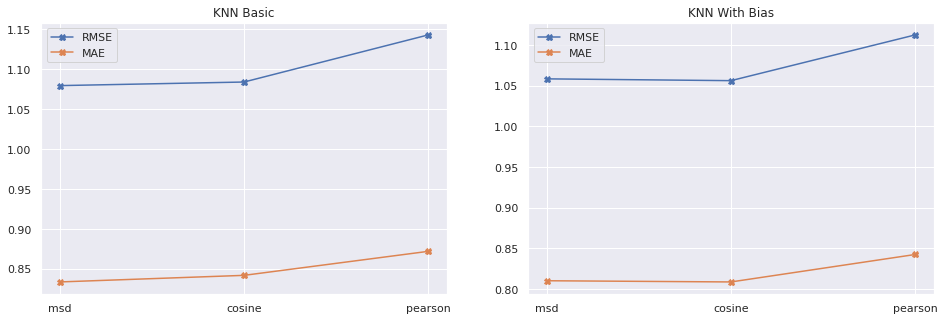

In [82]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

res = [(res['KNNBasic']['similarity'], res['KNNBasic']['rmse'], res['KNNBasic']['mae']) for res in results if 'KNNBasic' in res and not res['KNNBasic']['user_based']]
res = list(zip(*res))
metrics, rmse, mae = res[0], res[1], res[2]

axes[0].set_title('KNN Basic')
axes[0].plot(metrics, rmse, '-X', label='RMSE')
axes[0].plot(metrics, mae, '-X', label='MAE')
axes[0].legend()

res = [(res['KNNWithMeans']['similarity'], res['KNNWithMeans']['rmse'], res['KNNWithMeans']['mae']) for res in results if 'KNNWithMeans' in res and not res['KNNWithMeans']['user_based']]
res = list(zip(*res))
metrics, rmse, mae = res[0], res[1], res[2]

axes[1].set_title('KNN With Bias');
axes[1].plot(metrics, rmse, '-X', label='RMSE')
axes[1].plot(metrics, mae, '-X', label='MAE')
axes[1].legend()

## Paramter Tuning

In [12]:
param_grid = {
    "sim_options": {
        "name": ["msd", "cosine", "pearson"],
        "min_support": [3, 4, 5],
        "user_based": [True, False],
    }
}
grid_search = GridSearchCV(KNNWithMeans, param_grid, measures = ["rmse", "mae"], cv = 5)
grid_search.fit(Dataset.load_from_df(reviews_df, Reader(rating_scale=(1, 5))))

print(grid_search.best_score["rmse"])
print(grid_search.best_params["rmse"])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

## Recommending Businesses

In [53]:
def get_top_n(predictions, n=10):
    """
    This function returns the top n predictions for every user
    
    Parameters:
    
    predictions: ratings for every user predicted by the model
     results
    n: Number of restaurants to be recommended default is 10
    
    Returns:
    A dictionary with key as the user id and a list of businesses as the value
    """
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

def build_anti_dataset(user_id, reviews_df):
    businesses_already_rated_by_user = reviews_df[reviews_df['user_id'] == user_id]['business_id'].values
    businesses_not_rated_by_user = reviews_df[~reviews_df.business_id.isin(businesses_already_rated_by_user)].business_id
    
    anti_user_df = pd.DataFrame(businesses_not_rated_by_user).assign(user_id = user_id).assign(stars = np.nan)
    anti_user_df = anti_user_df[['user_id', 'business_id', 'stars']]
    
    return anti_user_df

In [54]:
## using a pandas dataframe ##
reader = Reader(rating_scale = (1, 5))
data = Dataset.load_from_df(reviews_df, reader)
trainset = data.build_full_trainset()

algo = KNNWithMeans(sim_options={'name': 'cosine', 'user_based': True, "min_support": 3})
algo.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [55]:
predictions = algo.test(testset)
precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=3)
accuracy.rmse(predictions, verbose=True)
# print('RMSE: ', )
print('Precision@5: ', sum(prec for prec in precisions.values()) / len(precisions))
print('Recall@5: ', sum(rec for rec in recalls.values()) / len(recalls))

print('MRR@5: ', mrr_at_k(predictions, k=5, threshold=3))
print('MRR_with_threshold@5: ', mrr_at_k_with_threshold(predictions, k=5, threshold=3))

RMSE: 0.8707
Precision@5:  0.9592210877801426
Recall@5:  0.557742414374102
MRR@5:  0.8812881268862777
MRR_with_threshold@5:  0.9941212354716497


In [56]:
# Selecting a user_id to recommend businesses to
user_id = reviews_df.iloc[0].user_id

# Building anti test set, i.e, selecting all businesses which user has not rated
anti_user_df = build_anti_dataset(user_id, reviews_df)

# Estimating business ratings
testset = Dataset.load_from_df(anti_user_df, reader).build_full_trainset().build_testset()
predictions = algo.test(testset)

# Recommending top 10 businesses wwith highest estimated ratings
top_n_antitest = get_top_n(predictions, 10)
top_n_antitest

defaultdict(list,
            {'UgMW8bLE0QMJDCkQ1Ax5Mg': [('swX3Vj3dQsz1YlCRmwNQEQ', 5),
              ('Xs2iTWxbczvfEapAFH3cyw', 5),
              ('C9QNd6qXSRgSy8n4OBf2mA', 5),
              ('swX3Vj3dQsz1YlCRmwNQEQ', 5),
              ('cUGFEQOu3_VsOpbvHGx8ZQ', 5),
              ('cj_9eTPR0JBqk9qt2VmzFw', 5),
              ('g9cKOi-6XzQne3s5TqA2fQ', 5),
              ('C9QNd6qXSRgSy8n4OBf2mA', 5),
              ('0CElIQnJdQYF2bmsAiWczg', 5),
              ('c9AIsznk1BtEYZp0gZio6A', 5)]})